# Импорт библиотек

In [2]:
import warnings
import re
import nltk
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DNS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DNS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DNS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DNS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Подготовка данных

Загружаем данные:

In [3]:
data = pd.read_csv('binary_data.csv')

Применяем функцию, убирающую слова-связки, а также лемматизирующую оставшиеся токены, к данным, а также векторизуем их. Сохраняем очищенные данные в `.csv`-файл, дополнительно сохраняем векторайзер в файл формата `.pkl`, он пригодится позднее:

In [4]:
lemm = WordNetLemmatizer()
stop_word = stopwords.words('english')
def clean(text):
  text = re.sub(r'[^\w\s]','', text, re.UNICODE)
  text = text.lower()
  text = [lemm.lemmatize(token) for token in text.split(' ')]
  text = [lemm.lemmatize(token, 'v') for token in text]
  cleanreview = " ".join(word for word in text if word not in stop_word)
  return cleanreview
data['Review'] = data['Review'].str.replace('''<br /><br />''', '')
data['Review'] = data['Review'].apply(clean)
data.to_csv('cleaned_data.csv')

In [5]:
tv = TfidfVectorizer(max_features = 5000)
X = tv.fit_transform(data['Review']).toarray()
Y = data['Sentiment']

In [6]:
joblib.dump(tv, 'vectorizer.pkl', compress = True)

['vectorizer.pkl']

Делим данные на обучающую и тестовую выборки, проверяем себя:

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.20,
                                                    random_state = 40)
print("Train:", f"X — {x_train.shape}; Y — {y_train.shape}")
print("Test:", f"X — {x_test.shape}; Y — {y_test.shape}")

Train: X — (39989, 5000); Y — (39989,)
Test: X — (9998, 5000); Y — (9998,)


# Логистическая регрессия

Определяем гиперпараметры модели, обучаем ее:

In [8]:
grid_logreg = {'penalty': ['l1', 'l2', 'elasticnet'],
               'C': [0.5, 1, 2],
               'solver': ['saga']}

logreg_fit = GridSearchCV(LogisticRegression(), grid_logreg, cv = 5, scoring = 'f1').fit(x_train, y_train)

logreg = logreg_fit.best_estimator_
logreg_pred = logreg.predict(x_test)

print('Tuned hpyerparameters (best parameters): ', logreg_fit.best_params_)
print('Best cross-validation score: ', logreg_fit.best_score_)

Tuned hpyerparameters (best parameters):  {'C': 2, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score:  0.8843739340905727


Составляем матрицу ошибок, получаем метрики:

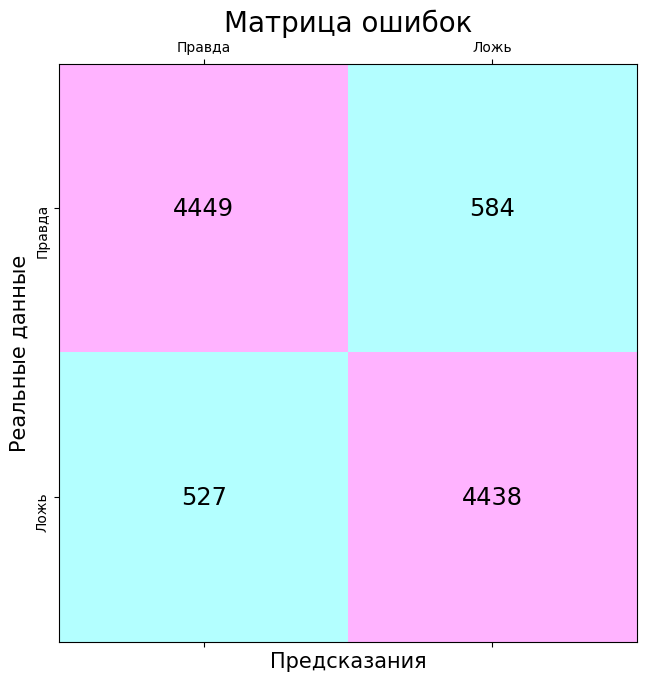

In [9]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = logreg_pred)
lab = ['Правда', 'Ложь']
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.matshow(conf_matrix, cmap = plt.cm.cool, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j,
                y = i,
                s = conf_matrix[i, j],
                va = 'center',
                ha = 'center',
                size = 'xx-large')
ax.set_xticklabels([''] + lab, fontsize = 10)
ax.set_yticklabels([''] + lab, fontsize = 10,  rotation = 'vertical')
plt.xlabel('Предсказания', fontsize = 15)
plt.ylabel('Реальные данные', fontsize = 15)
plt.title('Матрица ошибок', fontsize = 20)
plt.show()

In [10]:
print('Accuracy: ', metrics.accuracy_score(y_test, logreg_pred))
print('Precision: ', metrics.precision_score(y_test, logreg_pred))
print('Recall: ', metrics.recall_score(y_test, logreg_pred))
print('F1-score: ', metrics.f1_score(y_test, logreg_pred))

Accuracy:  0.888877775555111
Precision:  0.8837116686579052
Recall:  0.8938569989929507
F1-score:  0.8887553819965955


# Наивный Байес

Определяем гиперпараметры моделей, обучаем их:

In [11]:
# Gaussian Naive Bayes
grid_gauss = {'var_smoothing': [1e-3, 1e-5, 1e-7, 1e-9, 1e-11, 1e-13]}

gauss_nb = GridSearchCV(GaussianNB(), grid_gauss, cv = 5, scoring = 'f1').fit(x_train, y_train)
gauss = gauss_nb.best_estimator_
gauss_pred = gauss.predict(x_test)

print('Tuned hpyerparameters (best parameters) for Gaussian Bayes: ', gauss_nb.best_params_)
print('Best cross-validation score for Gaussian Bayes: ', gauss_nb.best_score_)

Tuned hpyerparameters (best parameters) for Gaussian Bayes:  {'var_smoothing': 0.001}
Best cross-validation score for Gaussian Bayes:  0.790933155038716


In [12]:
# Multinomial Naive Bayes
grid_multi = {'alpha': [0, 0.5, 1, 2],
              'fit_prior': [True, False],
              'force_alpha': [True, False]}

multi_nb = GridSearchCV(MultinomialNB(), grid_multi, cv = 5, scoring = 'f1').fit(x_train, y_train)
multi = multi_nb.best_estimator_
multi_pred = multi.predict(x_test)

print('Tuned hpyerparameters (best parameters) for Multinomial Bayes: ', multi_nb.best_params_)
print('Best cross-validation score for Multinomial Bayes: ', multi_nb.best_score_)

Tuned hpyerparameters (best parameters) for Multinomial Bayes:  {'alpha': 2, 'fit_prior': False, 'force_alpha': True}
Best cross-validation score for Multinomial Bayes:  0.8502590800400363


In [13]:
# Bernoulli Naive Bayes

grid_bern = {'alpha': [0, 0.5, 1, 2],
             'fit_prior': [True, False],
             'force_alpha': [True, False],
             'binarize': [None, 0]}

bern_nb = GridSearchCV(BernoulliNB(), grid_bern, cv = 5, scoring = 'f1').fit(x_train, y_train)
bern = bern_nb.best_estimator_
bern_pred = bern.predict(x_test)

print('Tuned hpyerparameters (best parameters) for Bernoulli Bayes: ', bern_nb.best_params_)
print('Best cross-validation score for Bernoulli Bayes: ', bern_nb.best_score_)

Tuned hpyerparameters (best parameters) for Bernoulli Bayes:  {'alpha': 2, 'binarize': None, 'fit_prior': True, 'force_alpha': True}
Best cross-validation score for Bernoulli Bayes:  0.8513153404800257


Отбираем лучшую модель по значению *Best cross-validaton score*, составляем матрицу ошибок, получаем метрики:

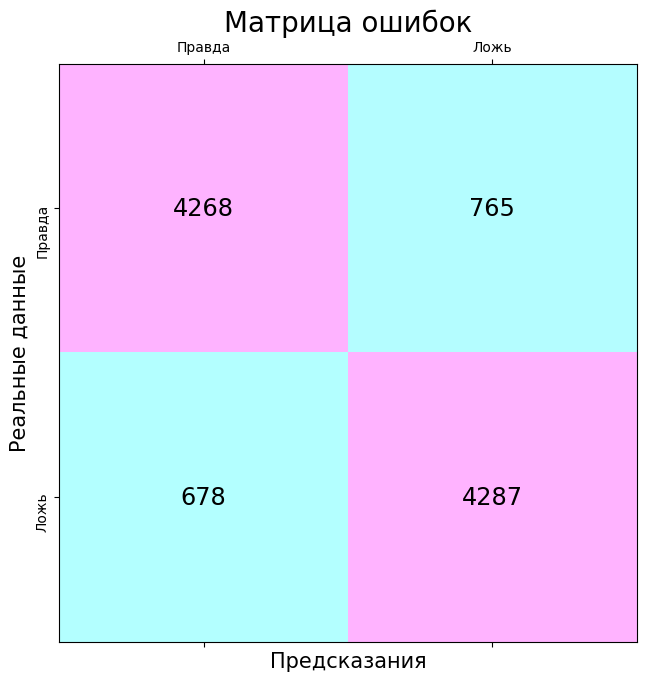

In [14]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = bern_pred)
lab = ['Правда', 'Ложь']
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.matshow(conf_matrix, cmap = plt.cm.cool, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j,
                y = i,
                s = conf_matrix[i, j],
                va = 'center',
                ha = 'center',
                size = 'xx-large')
ax.set_xticklabels([''] + lab, fontsize = 10)
ax.set_yticklabels([''] + lab, fontsize = 10,  rotation = 'vertical')
plt.xlabel('Предсказания', fontsize = 15)
plt.ylabel('Реальные данные', fontsize = 15)
plt.title('Матрица ошибок', fontsize = 20)
plt.show()

In [15]:
print('Accuracy: ', metrics.accuracy_score(y_test, bern_pred))
print('Precision: ', metrics.precision_score(y_test, bern_pred))
print('Recall: ', metrics.recall_score(y_test, bern_pred))
print('F1-score: ', metrics.f1_score(y_test, bern_pred))

Accuracy:  0.8556711342268454
Precision:  0.8485748218527316
Recall:  0.8634441087613293
F1-score:  0.8559448936807427


# Метод опорных векторов (SVM)

Определяем гиперпараметры модели, обучаем ее:

In [16]:
grid_svm = {'C': [0.1, 1, 2],
            'penalty': ['l1', 'l2'],
            'loss': ['hinge', 'squared_hinge'],
            'class_weight': ['balanced'],
            'max_iter': [1000, 2000]}

svm_fit = GridSearchCV(LinearSVC(), grid_svm, cv = 5, scoring = 'f1').fit(x_train, y_train)
svm = svm_fit.best_estimator_

svm_pred = svm.predict(x_test)

print('Tuned hpyerparameters (best parameters): ', svm_fit.best_params_)
print('Best cross-validaton score: ', svm_fit.best_score_)

Tuned hpyerparameters (best parameters):  {'C': 0.1, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}
Best cross-validaton score:  0.8849164298541086


Составляем матрицу ошибок, получаем метрики:

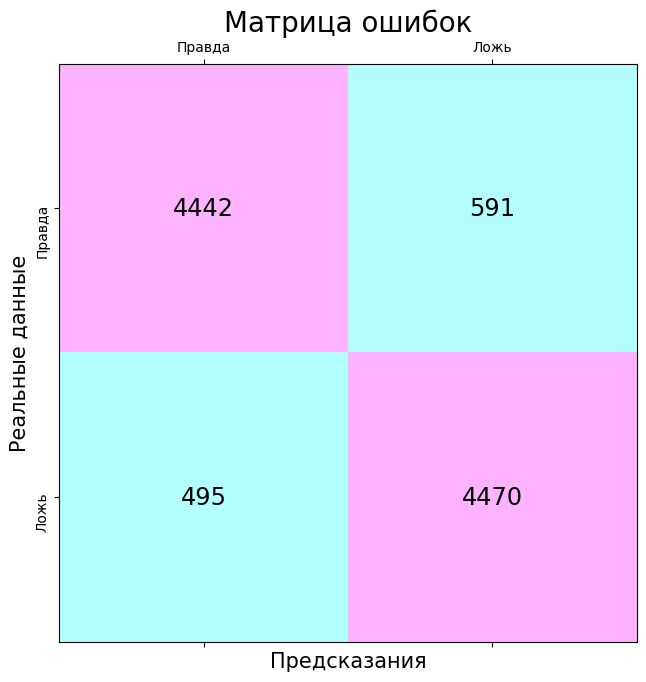

In [17]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = svm_pred)
lab = ['Правда', 'Ложь']
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.matshow(conf_matrix, cmap = plt.cm.cool, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j,
                y = i,
                s = conf_matrix[i, j],
                va = 'center',
                ha = 'center',
                size = 'xx-large')
ax.set_xticklabels([''] + lab, fontsize = 10)
ax.set_yticklabels([''] + lab, fontsize = 10,  rotation = 'vertical')
plt.xlabel('Предсказания', fontsize = 15)
plt.ylabel('Реальные данные', fontsize = 15)
plt.title('Матрица ошибок', fontsize = 20)
plt.show()

In [18]:
print('Accuracy: ', metrics.accuracy_score(y_test, svm_pred))
print('Precision: ', metrics.precision_score(y_test, svm_pred))
print('Recall: ', metrics.recall_score(y_test, svm_pred))
print('F1-score: ', metrics.f1_score(y_test, svm_pred))

Accuracy:  0.8913782756551311
Precision:  0.8832246591582691
Recall:  0.9003021148036254
F1-score:  0.8916816277678038


# Определение лучшей модели

В первую очередь сравним точность моделей со стандартным классификатором от NLTK:

In [19]:
def sentiment(text):
    scores = SentimentIntensityAnalyzer().polarity_scores(text)
    return 1 if scores['pos'] > 0 else 0

data['Test_nltk'] = data['Review'].apply(sentiment)

print('Accuracy: ', metrics.accuracy_score(data['Sentiment'], data['Test_nltk']))
print('Precision: ', metrics.precision_score(data['Sentiment'], data['Test_nltk']))
print('Recall: ', metrics.recall_score(data['Sentiment'], data['Test_nltk']))
print('F1-score: ', metrics.f1_score(data['Sentiment'], data['Test_nltk']))

Accuracy:  0.5021705643467301
Precision:  0.5011042846243424
Recall:  0.9985197039407882
F1-score:  0.6673172818545207


In [20]:
print('Basic F1-score: ', metrics.f1_score(data['Sentiment'], data['Test_nltk']))
print('F1-score of Logistic Regression: ', metrics.f1_score(y_test, logreg_pred))
print('F1-score of Naive Bayes model: ', metrics.f1_score(y_test, bern_pred))
print('F1-score of SVM model: ', metrics.f1_score(y_test, svm_pred))

Basic F1-score:  0.6673172818545207
F1-score of Logistic Regression:  0.8887553819965955
F1-score of Naive Bayes model:  0.8559448936807427
F1-score of SVM model:  0.8916816277678038


Основываясь на метриках, в качестве модели для веб-сервера выбираем SVM, сохраняем модель:

In [21]:
joblib.dump(svm, 'model.joblib')

['model.joblib']